In [61]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns

datasource = pq.read_table("escooter_history.parquet")

dataset = datasource.to_pandas()
print(dataset)

                   datetime  holiday  workingday            weather   temp  \
0       2019-01-01 00:00:09        0           0  clear, few clouds   9.84   
1       2019-01-01 00:00:41        0           0  clear, few clouds   9.84   
2       2019-01-01 00:01:20        0           0  clear, few clouds   9.84   
3       2019-01-01 00:04:12        0           0  clear, few clouds   9.84   
4       2019-01-01 00:15:19        0           0  clear, few clouds   9.84   
...                     ...      ...         ...                ...    ...   
3296016 2020-12-31 23:55:56        0           1  clear, few clouds  10.66   
3296017 2020-12-31 23:55:59        0           1  clear, few clouds  10.66   
3296018 2020-12-31 23:57:17        0           1  clear, few clouds  10.66   
3296019 2020-12-31 23:57:28        0           1  clear, few clouds  10.66   
3296020 2020-12-31 23:58:10        0           1  clear, few clouds  10.66   

          atemp  humidity  windspeed  registered_customer  
0  

In [62]:

dataset.describe()

,holiday,workingday,temp,atemp,humidity,windspeed
count,3.296021e+06,3.296021e+06,3.296021e+06,3.296021e+06,3.296021e+06,3.296021e+06
mean,2.708539e-02,6.914516e-01,2.330069e+01,2.694455e+01,5.667220e+01,1.344274e+01
std,1.623323e-01,4.618943e-01,7.417160e+00,7.960401e+00,1.825513e+01,8.042864e+00
min,0.000000e+00,0.000000e+00,8.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.722000e+01,2.121000e+01,4.200000e+01,7.001500e+00
50%,0.000000e+00,1.000000e+00,2.460000e+01,2.803000e+01,5.500000e+01,1.299800e+01
75%,0.000000e+00,1.000000e+00,2.952000e+01,3.257500e+01,7.000000e+01,1.900120e+01
max,1.000000e+00,1.000000e+00,4.100000e+01,5.000000e+01,1.000000e+02,5.699690e+01



# Werte liegen nicht atomar vor, weitere aufsplittung nicht möglich

In [63]:
newcols = pd.get_dummies(dataset["weather"])
print(newcols)

         clear, few clouds  cloudy, mist  \
0                        1             0   
1                        1             0   
2                        1             0   
3                        1             0   
4                        1             0   
...                    ...           ...   
3296016                  1             0   
3296017                  1             0   
3296018                  1             0   
3296019                  1             0   
3296020                  1             0   

         heacy rain or thunderstorm or snow or ice pallets  \
0                                                        0   
1                                                        0   
2                                                        0   
3                                                        0   
4                                                        0   
...                                                    ...   
3296016                              

In [64]:
dataset = dataset.drop(columns=['weather'])
print(dataset)

                   datetime  holiday  workingday   temp   atemp  humidity  \
0       2019-01-01 00:00:09        0           0   9.84  14.395        81   
1       2019-01-01 00:00:41        0           0   9.84  14.395        81   
2       2019-01-01 00:01:20        0           0   9.84  14.395        81   
3       2019-01-01 00:04:12        0           0   9.84  14.395        81   
4       2019-01-01 00:15:19        0           0   9.84  14.395        81   
...                     ...      ...         ...    ...     ...       ...   
3296016 2020-12-31 23:55:56        0           1  10.66  13.635        65   
3296017 2020-12-31 23:55:59        0           1  10.66  13.635        65   
3296018 2020-12-31 23:57:17        0           1  10.66  13.635        65   
3296019 2020-12-31 23:57:28        0           1  10.66  13.635        65   
3296020 2020-12-31 23:58:10        0           1  10.66  13.635        65   

         windspeed  registered_customer  
0           0.0000               

In [65]:
dataset = dataset.join(newcols)
print(dataset)

                   datetime  holiday  workingday   temp   atemp  humidity  \
0       2019-01-01 00:00:09        0           0   9.84  14.395        81   
1       2019-01-01 00:00:41        0           0   9.84  14.395        81   
2       2019-01-01 00:01:20        0           0   9.84  14.395        81   
3       2019-01-01 00:04:12        0           0   9.84  14.395        81   
4       2019-01-01 00:15:19        0           0   9.84  14.395        81   
...                     ...      ...         ...    ...     ...       ...   
3296016 2020-12-31 23:55:56        0           1  10.66  13.635        65   
3296017 2020-12-31 23:55:59        0           1  10.66  13.635        65   
3296018 2020-12-31 23:57:17        0           1  10.66  13.635        65   
3296019 2020-12-31 23:57:28        0           1  10.66  13.635        65   
3296020 2020-12-31 23:58:10        0           1  10.66  13.635        65   

         windspeed  registered_customer  clear, few clouds  cloudy, mist  \

In [66]:
dataset = dataset.rename(columns={'heacy rain or thunderstorm or snow or ice pallets' : 'Heavy Precipitation', 'light snow or rain or thunderstorm': 'Light Precipitation'})

In [67]:
print('datetime' + str(pd.unique(dataset["datetime"])))
print('holiday' + str(pd.unique(dataset["holiday"])))
print('workingday' + str(pd.unique(dataset["workingday"])))
print('temp' + str(pd.unique(dataset["temp"])))
print('atemp' + str(pd.unique(dataset["atemp"])))
print('humidity' + str(pd.unique(dataset["humidity"])))
print('windspeed' + str(pd.unique(dataset["windspeed"])))
print('registered customer' + str(pd.unique(dataset["registered_customer"])))
print('clear' + str(pd.unique(dataset["clear, few clouds"])))
print('cloudy' + str(pd.unique(dataset["cloudy, mist"])))

datetime['2019-01-01T00:00:09.000000000' '2019-01-01T00:00:41.000000000'
 '2019-01-01T00:01:20.000000000' ... '2020-12-31T23:57:17.000000000'
 '2020-12-31T23:57:28.000000000' '2020-12-31T23:58:10.000000000']
holiday[0 1]
workingday[0 1]
temp[ 9.84  9.02  8.2  13.12 15.58 14.76 17.22 18.86 18.04 16.4  13.94 12.3
 10.66  6.56  5.74  7.38  4.92 11.48  4.1   3.28  2.46  1.64  0.82 21.32
 22.96 23.78 24.6  19.68 22.14 20.5  27.06 26.24 25.42 27.88 28.7  30.34
 31.16 29.52 31.98 33.62 32.8  35.26 36.08 36.9  34.44 37.72 38.54 39.36
 40.18 41.  ]
atemp[14.395 13.635 12.88  17.425 19.695 16.665 21.21  22.725 21.97  20.455
 11.365 10.605  9.85   8.335  6.82   5.305  6.06   9.09  12.12   7.575
 15.91   3.03   3.79   4.545 15.15   1.515  2.275  0.     0.76  18.18
 25.    26.515 27.275 29.545 23.485 25.76  31.06  30.305 24.24  18.94
 31.82  32.575 33.335 28.79  28.03  34.09  34.85  37.12  38.635 37.88
 36.365 35.605 40.15  39.395 41.665 40.91  42.425 43.94  43.18  44.695
 46.21  45.455 47.725 49.2

In [68]:
dataset.dtypes
dataset[['holiday', 'workingday' ]] = dataset[['holiday', 'workingday']].replace({0:False, 1:True})
print(dataset)

                   datetime  holiday  workingday   temp   atemp  humidity  \
0       2019-01-01 00:00:09    False       False   9.84  14.395        81   
1       2019-01-01 00:00:41    False       False   9.84  14.395        81   
2       2019-01-01 00:01:20    False       False   9.84  14.395        81   
3       2019-01-01 00:04:12    False       False   9.84  14.395        81   
4       2019-01-01 00:15:19    False       False   9.84  14.395        81   
...                     ...      ...         ...    ...     ...       ...   
3296016 2020-12-31 23:55:56    False        True  10.66  13.635        65   
3296017 2020-12-31 23:55:59    False        True  10.66  13.635        65   
3296018 2020-12-31 23:57:17    False        True  10.66  13.635        65   
3296019 2020-12-31 23:57:28    False        True  10.66  13.635        65   
3296020 2020-12-31 23:58:10    False        True  10.66  13.635        65   

         windspeed  registered_customer  clear, few clouds  cloudy, mist  \

In [69]:
dataset.dtypes

datetime               datetime64[ns]
holiday                          bool
workingday                       bool
temp                          float64
atemp                         float64
humidity                        int64
windspeed                     float64
registered_customer           boolean
clear, few clouds               uint8
cloudy, mist                    uint8
Heavy Precipitation             uint8
Light Precipitation             uint8
dtype: object

In [70]:
subset = dataset.loc[dataset["humidity"] == 0]
#Replace 0 values with average humidity

In [71]:
dataset['Dates'] = pd.to_datetime(dataset['datetime']).dt.date
dataset['Time'] = pd.to_datetime(dataset['datetime']).dt.time

dataset['Weekday'] = pd.to_datetime(dataset['datetime']).dt.day_name()


#Hausaufgabe Leon
#cal = calendar()
#holidays = cal.holidays(start=dataset['Dates'].min(), end=dataset['Dates'].max())
#dataset['Holiday'] = dataset['Dates'].isin(holidays)


#dataset.head(50)

dataset.groupby(by=dataset['datetime'].dt.date).agg({
    'datetime': ['count'],
    'atemp': ['min', 'max', 'mean'],
    'windspeed': ['min', 'max', 'mean']
})



datetime   atemp                    windspeed                    
              count     min     max       mean       min      max       mean
datetime                                                                    
2019-01-01      985  12.880  22.725  20.405660    0.0000  19.9995  16.226271
2019-01-02      801  10.605  22.725  16.837996    8.9981  30.0026  15.875136
2019-01-03     1349   5.305  12.880  10.139789    0.0000  27.9993  14.724723
2019-01-04     1562   6.820  14.395  11.263326    0.0000  22.0028  12.351703
2019-01-05     1600   9.090  15.910  11.463716    0.0000  22.0028  14.113181
...             ...     ...     ...        ...       ...      ...        ...
2020-12-27     4231   9.850  13.635  11.515609   11.0014  35.0008  22.242182
2020-12-28     4629  10.605  15.910  12.771144    0.0000  19.0012  10.219380
2020-12-29     3087  12.120  12.120  12.120000    0.0000  36.9974   7.881757
2020-12-30     2886   9.850  18.180  12.108261    0.0000  43.9989  24.581467
2020-12-31     4429   7.575  14.395  11.673123    6.0032  15.0013   9.798979

[731 rows x 7 columns]

In [72]:
corr = dataset.corr()
corr

,holiday,workingday,temp,atemp,humidity,windspeed,registered_customer,"clear, few clouds","cloudy, mist",Heavy Precipitation,Light Precipitation
holiday,1.000000,-0.249775,-0.001709,-0.002556,0.005478,-0.008466,-0.028979,0.002186,0.006807,-0.001424,-0.018323
workingday,-0.249775,1.000000,-0.014320,-0.017877,0.064201,-0.023028,0.215538,-0.051499,0.044219,0.001774,0.020733
temp,-0.001709,-0.014320,1.000000,0.981454,-0.170779,0.011389,-0.134215,0.140562,-0.123311,-0.017877,-0.050787
atemp,-0.002556,-0.017877,0.981454,1.000000,-0.142046,-0.014511,-0.133984,0.137225,-0.119264,-0.017906,-0.051819
humidity,0.005478,0.064201,-0.170779,-0.142046,1.000000,-0.268500,0.092715,-0.401335,0.295019,0.014050,0.261467
windspeed,-0.008466,-0.023028,0.011389,-0.014511,-0.268500,1.000000,-0.024510,0.046221,-0.067428,-0.004548,0.037403
registered_customer,-0.028979,0.215538,-0.134215,-0.133984,0.092715,-0.024510,1.000000,-0.039332,0.029310,0.003274,0.024748
"clear, few clouds",0.002186,-0.051499,0.140562,0.137225,-0.401335,0.046221,-0.039332,1.000000,-0.885191,-0.013399,-0.349941
"cloudy, mist",0.006807,0.044219,-0.123311,-0.119264,0.295019,-0.067428,0.029310,-0.885191,1.000000,-0.004811,-0.125647
Heavy Precipitation,-0.001424,0.001774,-0.017877,-0.017906,0.014050,-0.004548,0.003274,-0.013399,-0.004811,1.000000,-0.001902


<AxesSubplot:>

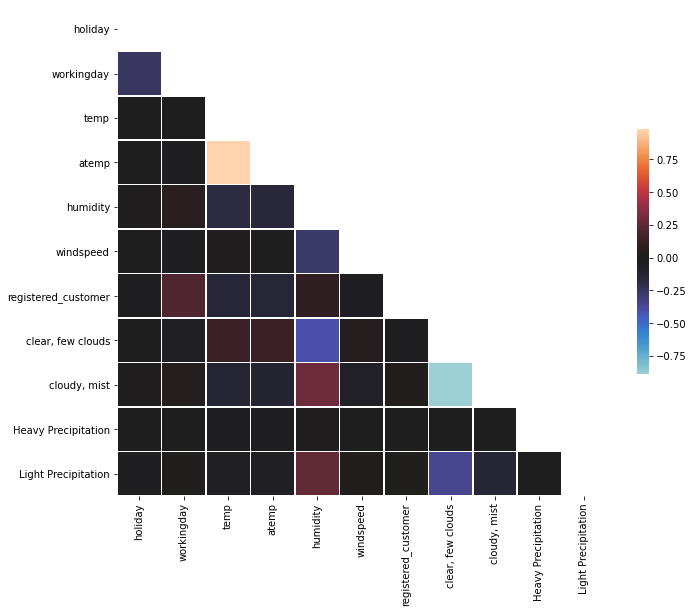

In [76]:

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask,center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})